In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 12

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

from sklearn.neighbors import NearestNeighbors

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [2]:
fname,fnamey="x_12d.dat","y_12d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  L=D=",D)
x=data

N= 600   L=D= 12


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

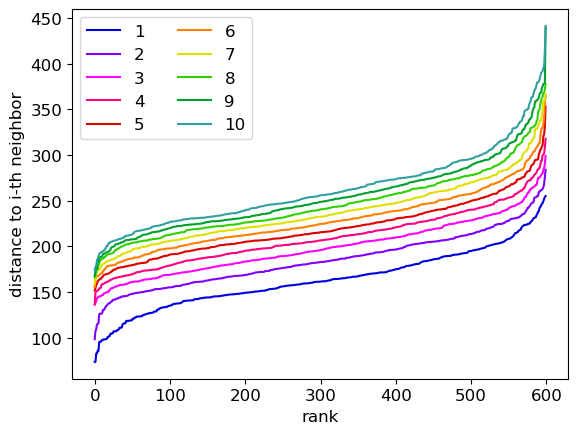

mean minimum distance between points:  163.65491354345073


In [3]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
d, ind = nbrs.kneighbors(x)
dd=d.T
# note: dd[0] has a trivial set of zeros
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.show()
mean_min_dist = np.mean(dd[1])
print("mean minimum distance between points: ",mean_min_dist)

## t-SNE visualization, for true labels

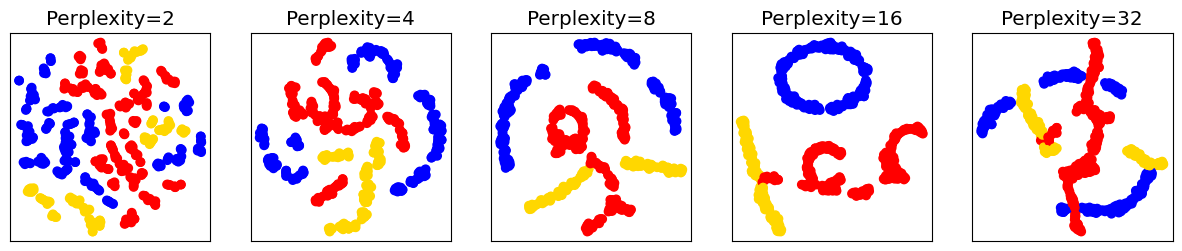

In [4]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [2, 4, 8, 16, 32]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## Different random initial states (random_state=i)

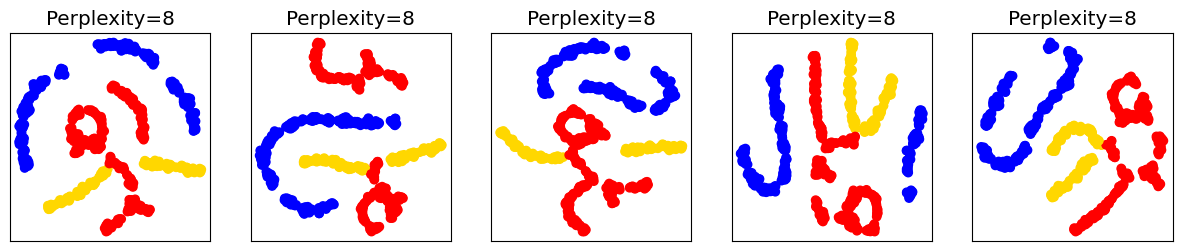

In [5]:
n_samples = N
n_components = 2 
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]

perplexity= 8

for i in range(Np):
    np.random.seed(i) 
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, 
                         init='random',random_state=i, 
                         perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## DBSCAN: find labels by applying clustering

In [6]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46",
            "#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF",
            "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C",
            "#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81",
            "#575329", "#00FECF", "#B05B6F"]


def clustering(y):
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    h = 0.
    for kc in c.keys():
        p = len(c[kc]) / n_sample
        h += p * np.log(p)
    h *= -1.
    return h

def NMI(y_true, y_pred):
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c = len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c * np.log(n_sample * w_intersect_c / (len(w[kw]) * len(c[kc])))
    Iwc /= n_sample
    Hc = entropy(c, n_sample)
    Hw = entropy(w, n_sample)
    
    return 2 * Iwc / (Hc + Hw)

# Imposta il seed per la riproducibilità e definisci il dataset (assumendo che X_all, data, y, mean_min_dist ecc. siano già definiti)
np.random.seed(12345)
n_true_center = 3

X2D = X_all[2]  # Visualizzazione 2D
X = data
y_true = y

# Definiamo gli intervalli per ε (10 a 300 a passi di 10) e min_samples (1 a 50 a passi di 1)
eps_range = np.arange(10, 301, 10)
min_sample_range = np.arange(1, 51, 1)

DIMY = len(eps_range)
DIMX = len(min_sample_range)

# Inizializza la matrice per salvare i valori NMI
nmi_matrix = np.zeros((DIMY, DIMX))

# Loop sui valori di ε e mP
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        nmi_value = NMI(y_hat, y_true)
        nmi_matrix[i, j] = nmi_value




# Correlation between ε (epsilon) and mP (min_samples)

In clustering, we use two parameters: **ε (epsilon)**, which controls the radius of the neighborhood, and **mP (min_samples)**, which defines the minimum number of points required to form a cluster. The **Normalized Mutual Information (NMI)** is used to measure how well the clustering algorithm (like DBSCAN) matches the true cluster labels.

## What is NMI?

**NMI** is a measure of the similarity between two clusterings, the true clustering and the predicted clustering. It ranges from 0 to 1:
- **0** means no similarity between the clusterings.
- **1** means perfect similarity between the clusterings.

The formula for NMI is:

$$
\text{NMI}(A, B) = \frac{2 \, I(A, B)}{H(A) + H(B)}
$$

where:
- \(I(A, B)\) is the **Mutual Information** between the true and predicted clusters.
- \(H(A)\) and \(H(B)\) are the **Entropy** of the true and predicted clusters, respectively.

## Correlation Between ε and mP

In our analysis, we look at how the NMI changes with different values of **ε** and **mP**. If the high NMI values appear in specific regions of the heatmap (where **ε** and **mP** have certain values), this indicates a **correlation** between **ε** and **mP** in achieving better clustering. For example:
- If high NMI values appear when both **ε** and **mP** are large, it suggests that a larger **ε** and **mP** lead to better clustering results.
- If high NMI values appear when both are small, then smaller values of both parameters are better.

### Conclusion

By observing the heatmap, we can tell if there's a correlation between **ε** and **mP** and how these parameters affect the clustering performance.


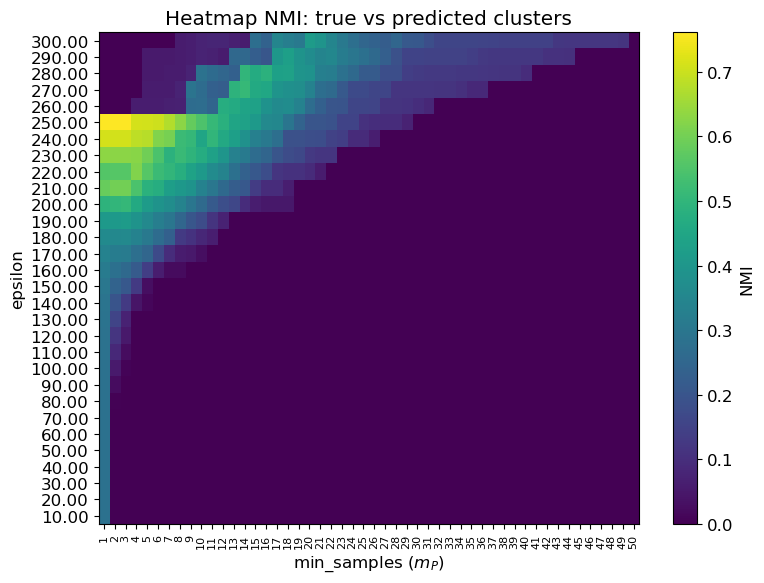

In [109]:
# Creazione della heatmap per visualizzare NMI in funzione di ε e mP
plt.figure(figsize=(8, 6))
# Visualizza la heatmap; origin='lower' per far corrispondere l'asse y all'ordine crescente di eps_range
im = plt.imshow(nmi_matrix, origin='lower', aspect='auto', cmap='viridis')

# Aggiungi la barra dei colori
cbar = plt.colorbar(im)
cbar.set_label('NMI')

# Imposta le etichette degli assi
plt.xlabel('min_samples ($m_P$)')
plt.ylabel('epsilon')

# Imposta i tick corrispondenti alle posizioni centrali delle celle
plt.xticks(np.arange(DIMX), min_sample_range)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(np.arange(DIMY), ["%.2f" % eps for eps in eps_range])

plt.title('Heatmap NMI: true vs predicted clusters')
plt.tight_layout()
plt.show()


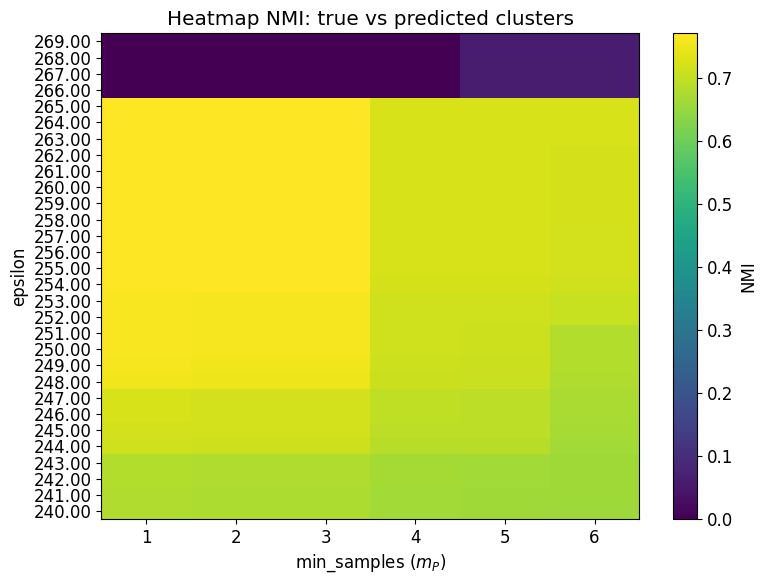

In [8]:
# Loop sui valori di ε e mP
eps_range = np.arange(240, 270, 1)
min_sample_range = np.arange(1, 7, 1)


DIMY = len(eps_range)
DIMX = len(min_sample_range)

# Inizializza la matrice per salvare i valori NMI
nmi_matrix = np.zeros((DIMY, DIMX))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        nmi_value = NMI(y_hat, y_true)
        nmi_matrix[i, j] = nmi_value

# Creazione della heatmap per visualizzare NMI in funzione di ε e mP
plt.figure(figsize=(8, 6))
# Visualizza la heatmap; origin='lower' per far corrispondere l'asse y all'ordine crescente di eps_range
im = plt.imshow(nmi_matrix, origin='lower', aspect='auto', cmap='viridis')

# Aggiungi la barra dei colori
cbar = plt.colorbar(im)
cbar.set_label('NMI')

# Imposta le etichette degli assi
plt.xlabel('min_samples ($m_P$)')
plt.ylabel('epsilon')

# Imposta i tick corrispondenti alle posizioni centrali delle celle
plt.xticks(np.arange(DIMX), min_sample_range)
plt.yticks(np.arange(DIMY), ["%.2f" % eps for eps in eps_range])

plt.title('Heatmap NMI: true vs predicted clusters')
plt.tight_layout()
plt.show()


### Since DB- Clustering is an invasive algorithm we can see that above epsilon = 265 the NMI drops drastically to 0, meaning that in this case this is the threshold for dividing two or more clusters, with the refined comparison we perform another DB-clustering and see the different results.
### As we can see from below, the DB Clustering algorithm is not able to correctly identify the 3 clusters separately, we can also see this from the heatmap since we don't obtain a value higher that roughly 0.7

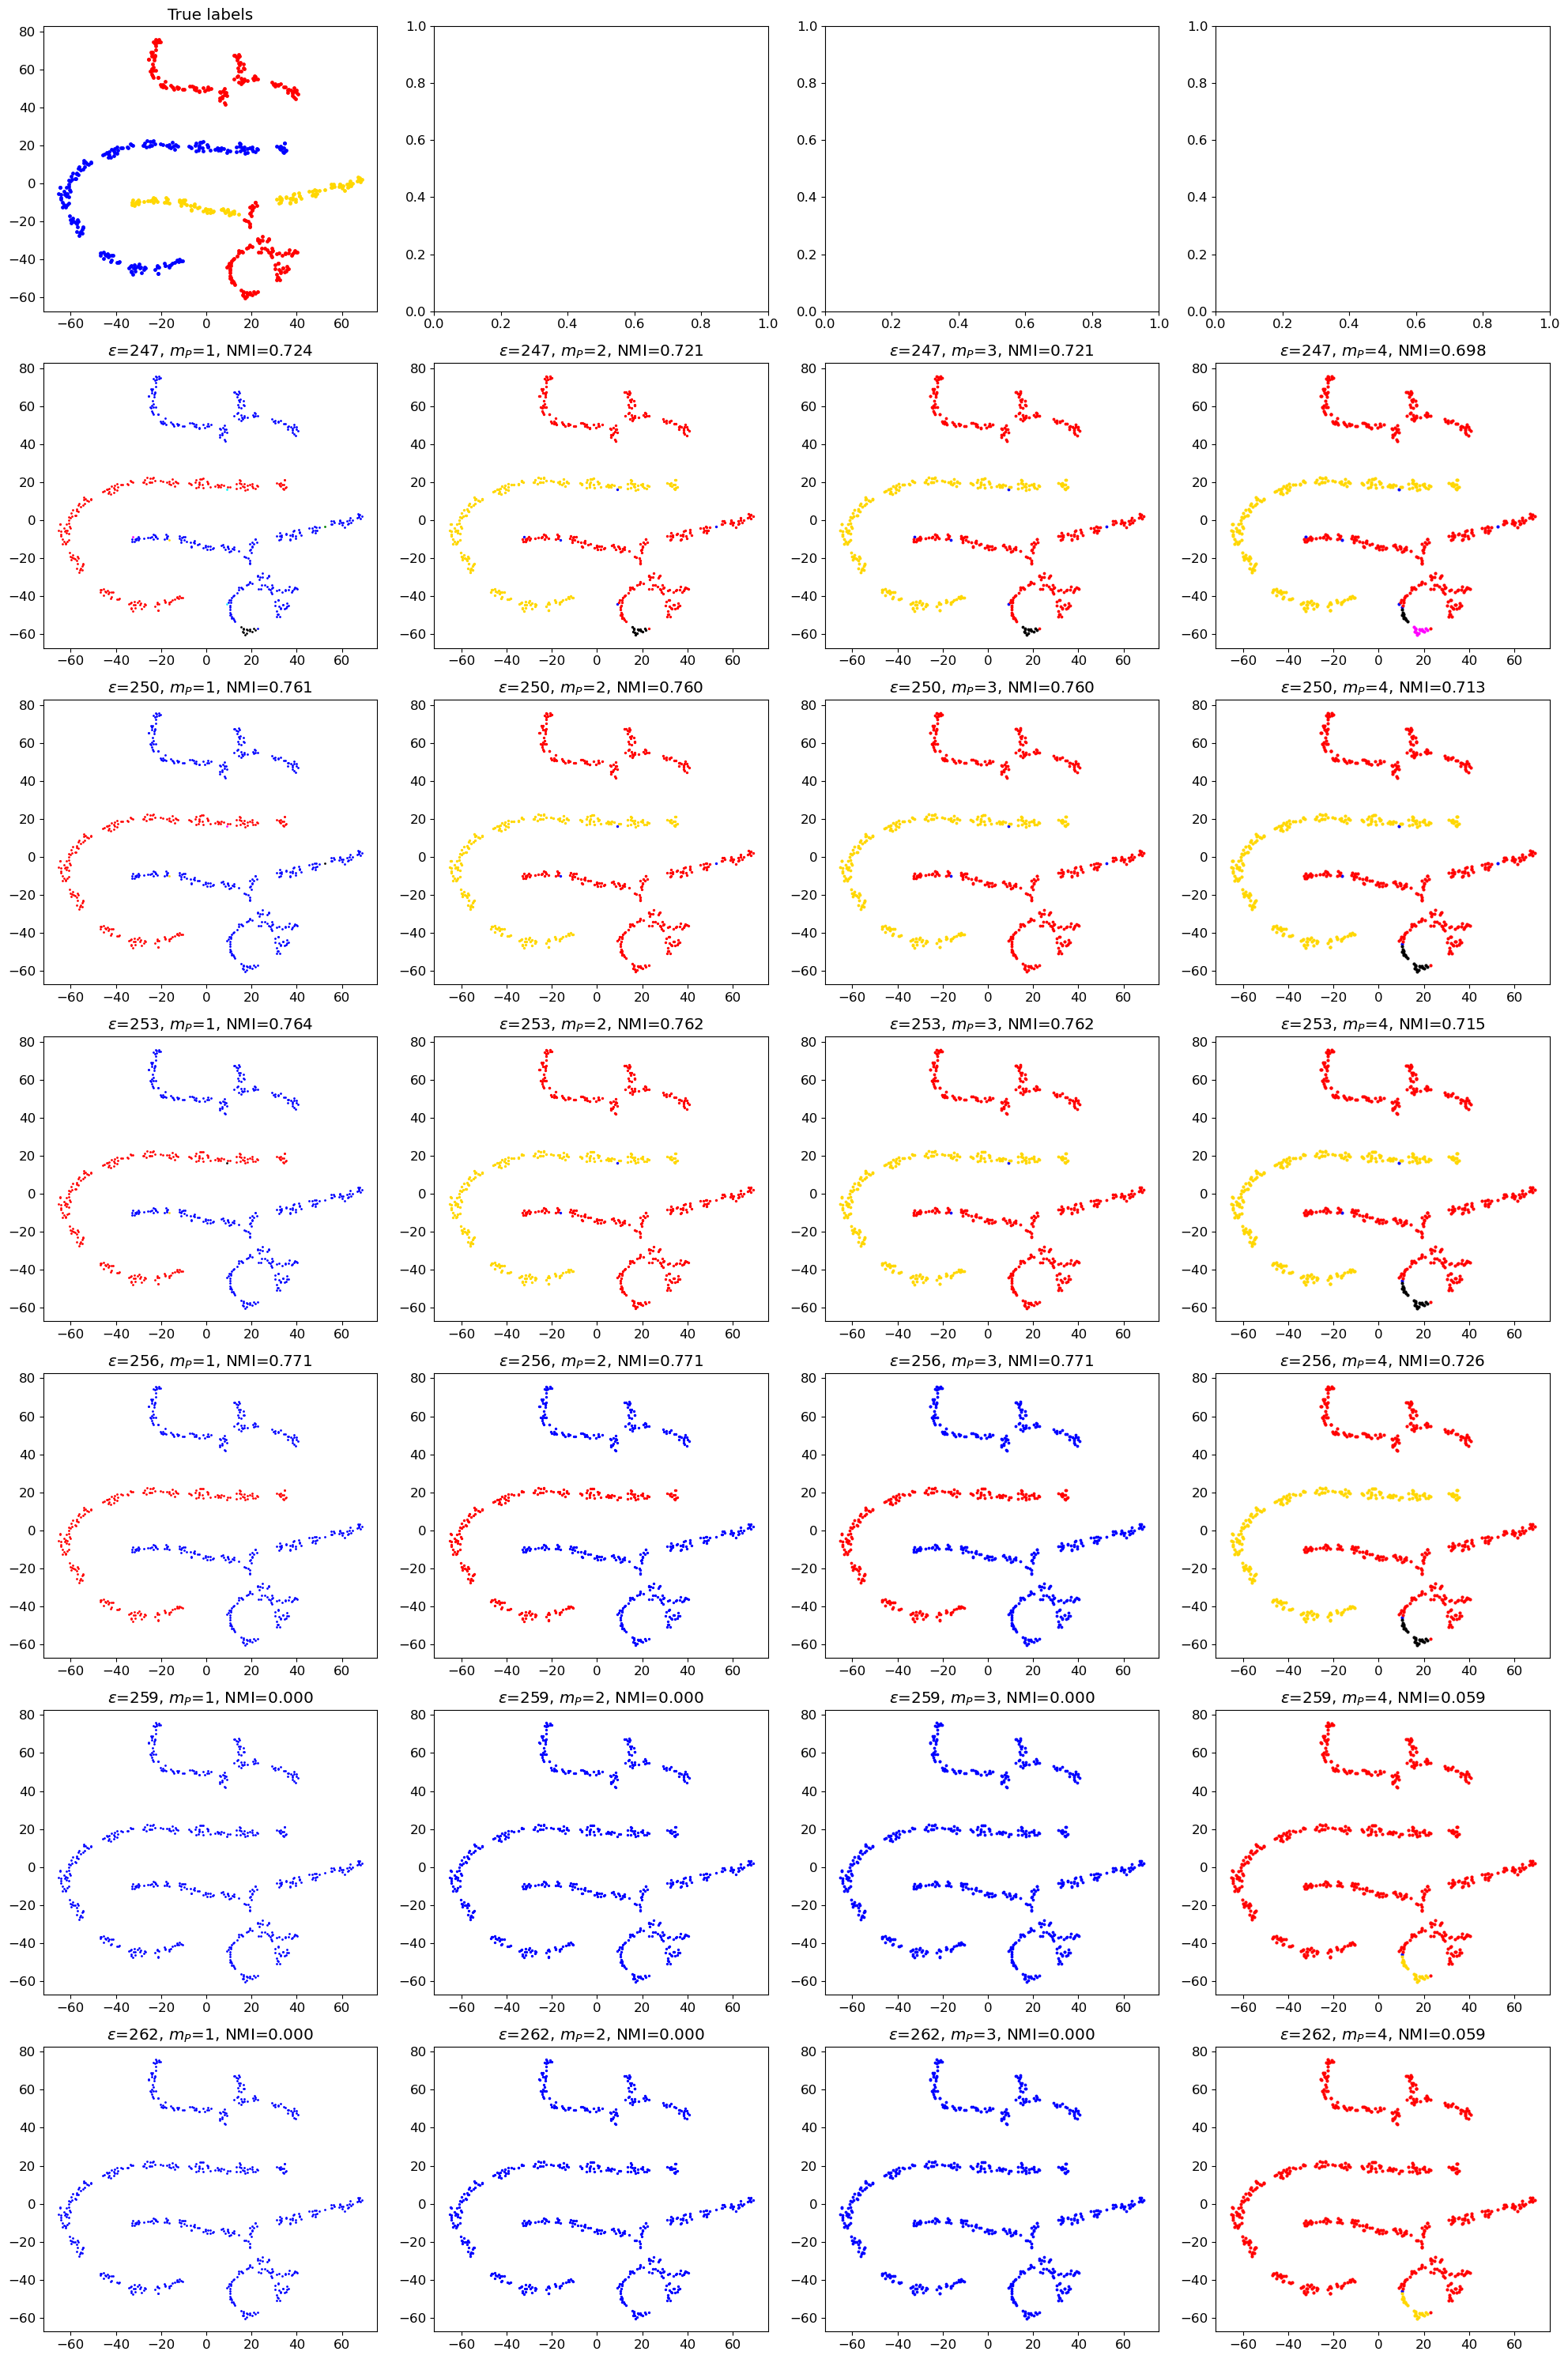

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN

cpalette = ["blue", "red", "gold", "black", "magenta", "green", "cyan", "#1CE6FF", "#FF34FF", "#FF4A46",
            "#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
            "#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#886F4C", "#34362D", "#B4A8BD",
            "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81", "#575329", "#00FECF", "#B05B6F"]
ms = 6

def plotting_ax(X, y, ax):
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos, 0], X[pos, 1], c=cpalette[i % len(cpalette)], s=6)

def plotting_axs(X, y, ax, ms):
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos, 0], X[pos, 1], c=cpalette[i % len(cpalette)], s=ms)

# Definiamo gli intervalli per ε (10 a 300 a passi di 10) e min_samples (1 a 50 a passi di 1)
eps_range = np.arange(247, 265, 3)
min_sample_range = np.arange(1, 5, 1)

DIMY = len(eps_range)
DIMX = len(min_sample_range)

# Inizializza la matrice per salvare i valori NMI
nmi_matrix = np.zeros((DIMY, DIMX))

# Prepara una griglia per visualizzare i clustering ottenuti e salva i valori NMI
# Modifica il figsize per fare spazio sufficiente per almeno 4 plot per riga
fig, ax = plt.subplots(DIMY + 1, DIMX, figsize=(20, 30))  # Adjusted figsize for more plots per row

# Plot dei dati con le etichette vere (prima riga)
plotting_ax(X2D, y, ax[0, 0])
ax[0, 0].set_title('True labels')

# Inizializza la matrice per salvare i valori NMI
nmi_matrix = np.zeros((DIMY, DIMX))

# Loop sui valori di ε e mP
y_best=np.zeros(len(X2D[:,1]))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_axs(X2D, y_hat, ax[i + 1, j], ms=min_samples)
        nmi_value = NMI(y_hat, y_true)
        nmi_matrix[i, j] = nmi_value
        ax[i + 1, j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f' % (eps, min_samples, nmi_value))
        if (i==0 and j==0): 
            nmi_max=nmi_value
            y_best=y_hat
        elif (nmi_matrix[i, j]>nmi_max):
            nmi_max=nmi_matrix[i, j]
            y_best=y_hat

# Adjust the layout to avoid overlap of titles and labels
plt.tight_layout(h_pad=1.0)
plt.show()


# Relation Between Optimal ε and the mP-th Ranked Distances in DBSCAN

The optimal **ε** corresponds to the distance where a clear separation between clusters and noise can be made. This can be visualized by plotting the ranked distances to the **mP-th** neighbor for all points and identifying the "elbow" point, which marks a significant increase in the distance. This elbow point typically represents the optimal **ε** value.

The **mP-th distance** is the distance to the **mP-th closest neighbor**.
The plot the **mP-th** neighbor's distances will often show a sharp increase, indicating a transition from dense regions to sparser regions (noise).
The **optimal ε** is typically the value where the plot shows a sharp increase or "elbow," marking the threshold where points start to become distant from each other.


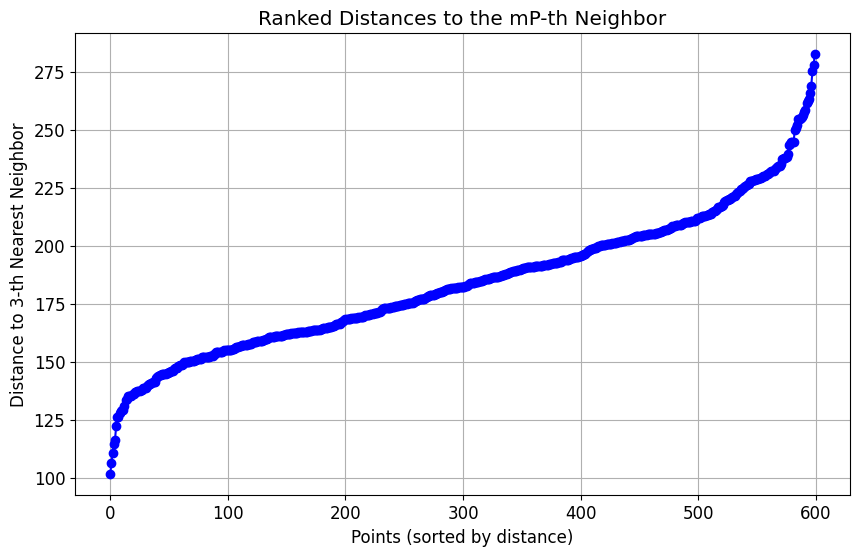

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Assuming X is your data

mP = 3  # min_samples
# Find nearest neighbors for each point in the dataset
neighbors = NearestNeighbors(n_neighbors=mP)
neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

# distances[:, -1] gives the distance to the mP-th neighbor
mP_distances = distances[:, -1]

# Sort the mP-th distances in ascending order
sorted_distances = np.sort(mP_distances)

# Plot the ranked distances to the mP-th neighbor
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances, marker='o', linestyle='-', color='b')
plt.title('Ranked Distances to the mP-th Neighbor')
plt.xlabel('Points (sorted by distance)')
plt.ylabel(f'Distance to {mP}-th Nearest Neighbor')
plt.grid(True)
plt.show()


# PCA: Principal Component Analysis

In [8]:
from scipy import linalg as la
# transpose data matrix
dataT = data.T
# find eigenvalues and eigenvectors of covariance matrix and sort them by principal component
U, spectrum, Vt = la.svd(dataT)
l = spectrum**2 / (data.shape[1] - 1)

Lambda = np.real_if_close(np.diag(l))

princ_comp = []

for i in range(Lambda.shape[0]):
    princ_comp.append(Lambda[i, i]/Lambda.trace())
    print(f'variability using up to PC {i+1}: {np.round(np.cumsum(princ_comp)[i] * 100, 1)} %')


variability using up to PC 1: 56.1 %
variability using up to PC 2: 86.3 %
variability using up to PC 3: 96.4 %
variability using up to PC 4: 96.9 %
variability using up to PC 5: 97.3 %
variability using up to PC 6: 97.8 %
variability using up to PC 7: 98.2 %
variability using up to PC 8: 98.6 %
variability using up to PC 9: 99.0 %
variability using up to PC 10: 99.3 %
variability using up to PC 11: 99.7 %
variability using up to PC 12: 100.0 %


The first three principal components capture 96% of the data's variability. We then project the data onto this reduced basis to retain most of its information while simplifying its representation.

In [9]:
rotated_data = np.dot(U, dataT)
rotated_data_0 = rotated_data.T[y_true == 0]
rotated_data_1 = rotated_data.T[y_true.T == 1]
rotated_data_2 = rotated_data.T[y_true.T == 2]

print(np.shape(rotated_data))

(12, 600)


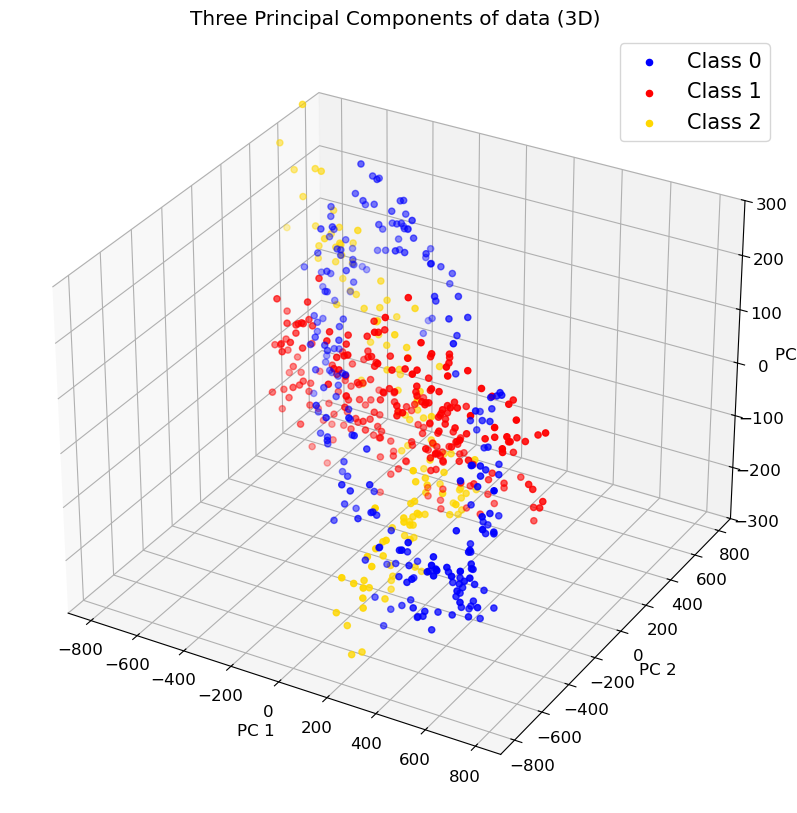

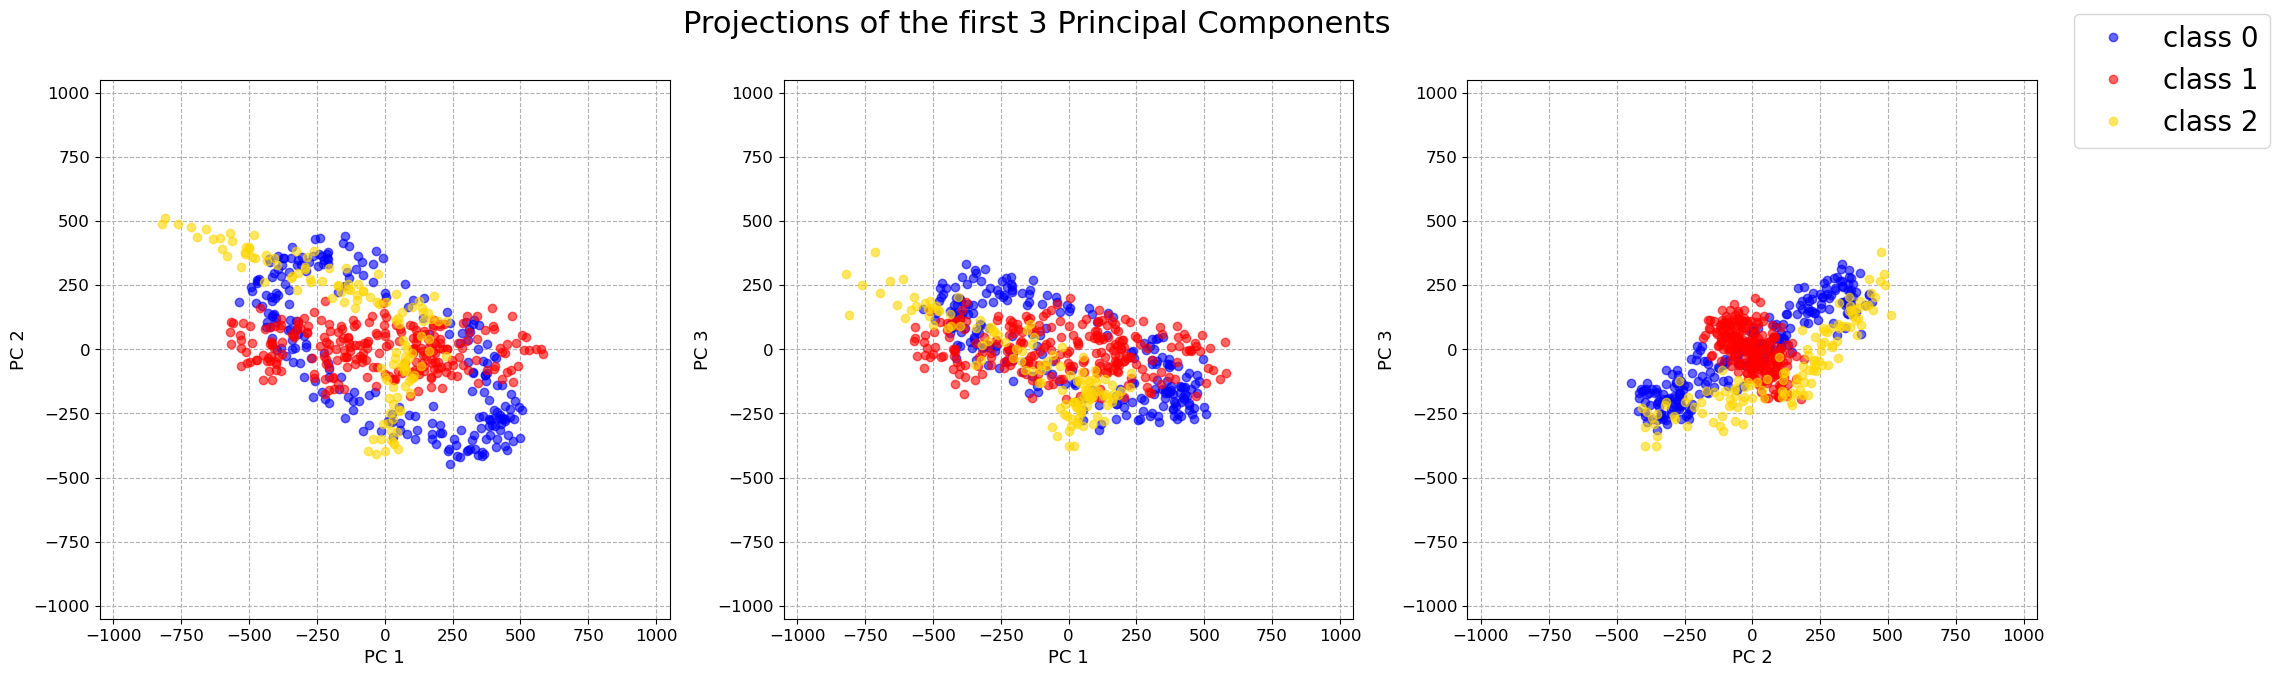

In [10]:
# plot the first three principal component rotated data
scale_factor = 0.005

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(rotated_data_0[:,0], rotated_data_0[:,1], rotated_data_0[:,2], label='Class 0', c='blue')
ax.scatter3D(rotated_data_1[:,0], rotated_data_1[:,1], rotated_data_1[:,2], label='Class 1', c='red')
ax.scatter3D(rotated_data_2[:,0], rotated_data_2[:,1], rotated_data_2[:,2], label='Class 2', c='gold')
ax.set_xlim(-900,900)
ax.set_ylim(-900,900)
ax.set_zlim(-300,300)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend(fontsize=15)
plt.title('Three Principal Components of data (3D)')
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (25, 7))

maxlim = 1050

ax[0].plot(rotated_data_0[:, 0], rotated_data_0[:, 1], 'o', alpha = .6, label = 'class 0', c='blue')
ax[0].plot(rotated_data_1[:, 0], rotated_data_1[:, 1], 'o', alpha = .6, label = 'class 1', c='red')
ax[0].plot(rotated_data_2[:, 0], rotated_data_2[:, 1], 'o', alpha = .6, label = 'class 2', c='gold')
ax[0].set_xlim(-maxlim, maxlim)
ax[0].set_ylim(-maxlim, maxlim)
ax[0].set_xlabel('PC 1', fontsize=13)
ax[0].set_ylabel('PC 2', fontsize=13)
ax[0].grid(True, linestyle='--')

ax[1].plot(rotated_data_0[:, 0], rotated_data_0[:, 2], 'o', alpha = .6, c = 'blue')
ax[1].plot(rotated_data_1[:, 0], rotated_data_1[:, 2], 'o', alpha = .6, c = 'red')
ax[1].plot(rotated_data_2[:, 0], rotated_data_2[:, 2], 'o', alpha = .6, c = 'gold')
ax[1].set_xlim(-maxlim, maxlim)
ax[1].set_ylim(-maxlim, maxlim)
ax[1].set_xlabel('PC 1', fontsize=13)
ax[1].set_ylabel('PC 3', fontsize=13)
ax[1].grid(True, linestyle='--')

ax[2].plot(rotated_data_0[:, 1], rotated_data_0[:, 2], 'o', alpha = .6, c = 'blue')
ax[2].plot(rotated_data_1[:, 1], rotated_data_1[:, 2], 'o', alpha = .6, c = 'red')
ax[2].plot(rotated_data_2[:, 1], rotated_data_2[:, 2], 'o', alpha = .6, c = 'gold')
ax[2].set_xlim(-maxlim, maxlim)
ax[2].set_ylim(-maxlim, maxlim)
ax[2].set_xlabel('PC 2', fontsize=13)
ax[2].set_ylabel('PC 3', fontsize=13)
ax[2].grid(True, linestyle='--')

fig.legend(fontsize=20)
fig.suptitle('Projections of the first 3 Principal Components', fontsize=22)
plt.show()

It can be seen from the first plot above that the dimensional reducted dataset up to the first 2 Principal Components still maintains its structure and 3 clusters are very recognizable.

# K-means clustering

Let's brutally apply K-means to the 12 dimensional data and compare the results with the best result from DBSCAN, with 'best' defined according to NMI

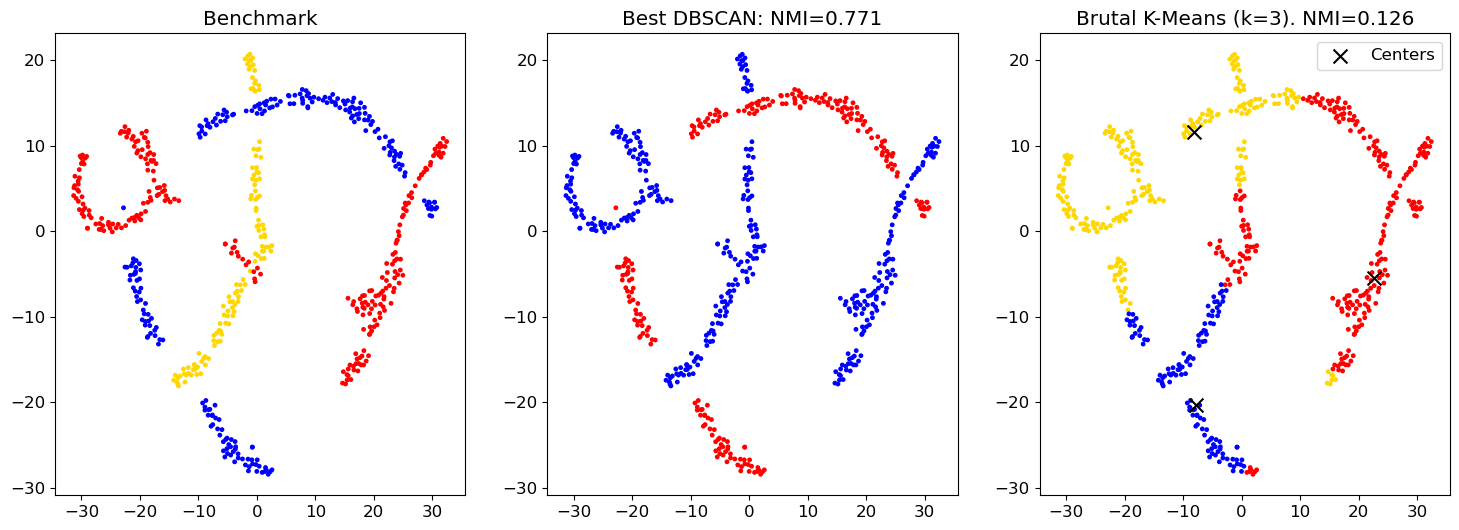

In [29]:
from sklearn.cluster import KMeans

fname = "x_12d.dat"
fnamey = "y_12d.dat"

data = np.loadtxt(fname, delimiter='\t')
y_true = np.loadtxt(fnamey, dtype=int)


k=3 #number of clusters

kmeans = KMeans(n_clusters=k, n_init=40) #n_init=40 <--> do 40 repetitions of the k-mean caculation, each time starting from a different point
y_kmeans = kmeans.fit_predict(data)  # Cluster labels assigned by k-means
centers = kmeans.cluster_centers_

mycmap = ListedColormap(["blue", "red", "gold"])

nmi_kmeans = NMI(y_true, y_kmeans)

fig, ax = plt.subplots(1,3,figsize=(18, 6))

combined = np.vstack([data, kmeans.cluster_centers_])
tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=30)
combined_embedded = tsne.fit_transform(combined)
n_samples = data.shape[0]
data_embedded = combined_embedded[:n_samples, :]
centers_embedded = combined_embedded[n_samples:, :]

ax[0].scatter(data_embedded[:, 0], data_embedded[:, 1], c=y_true, cmap=mycmap, s=6) #plot the true results
ax[0].set_title('Benchmark')

ax[1].scatter(data_embedded[:, 0], data_embedded[:, 1], c=y_best, vmin=0, vmax=2, cmap=mycmap, s=6) #best DBSCAN result 
#vmin e max are needed bc otherwise, since y_best contains just ones and zeroes, python bugs and considers 1 as max val of the cmap instead of 2
ax[1].set_title(f'Best DBSCAN: NMI={nmi_max:.3f}')

ax[2].scatter(data_embedded[:, 0], data_embedded[:, 1], c=y_kmeans, vmin=0, vmax=2, cmap=mycmap, s=6) 
ax[2].scatter(centers_embedded[:, 0], centers_embedded[:, 1], color='Black', marker='x', s=100, label='Centers')
ax[2].set_title(f"Brutal K-Means (k=3). NMI={nmi_kmeans:.3f}")
ax[2].legend()

It works very poorly, so let's try to denoise the data, via PCA. Infact looking at the results of the PCA analysis performed in the previous pararaph, since the amount of additional variance expained by the components 4-12 is a fraction of a unit, we may consider them as noise. This confirms, has it has already been said, that PCA works on this dataset because the dataset was infact built using just 3 meaningful directions; the others were chosen as noise.

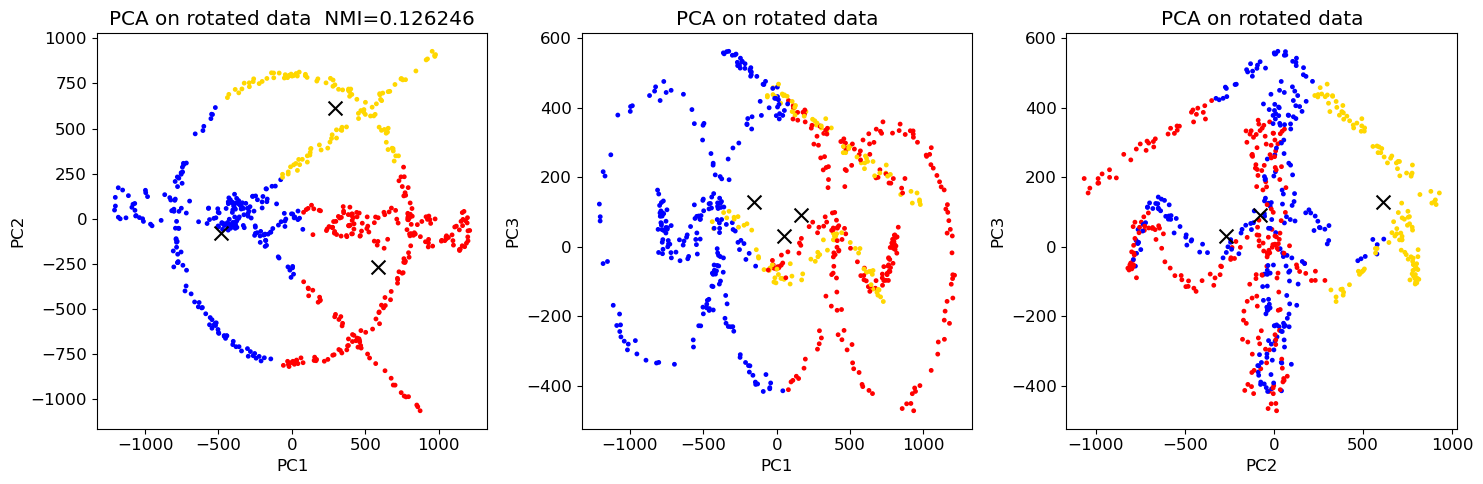

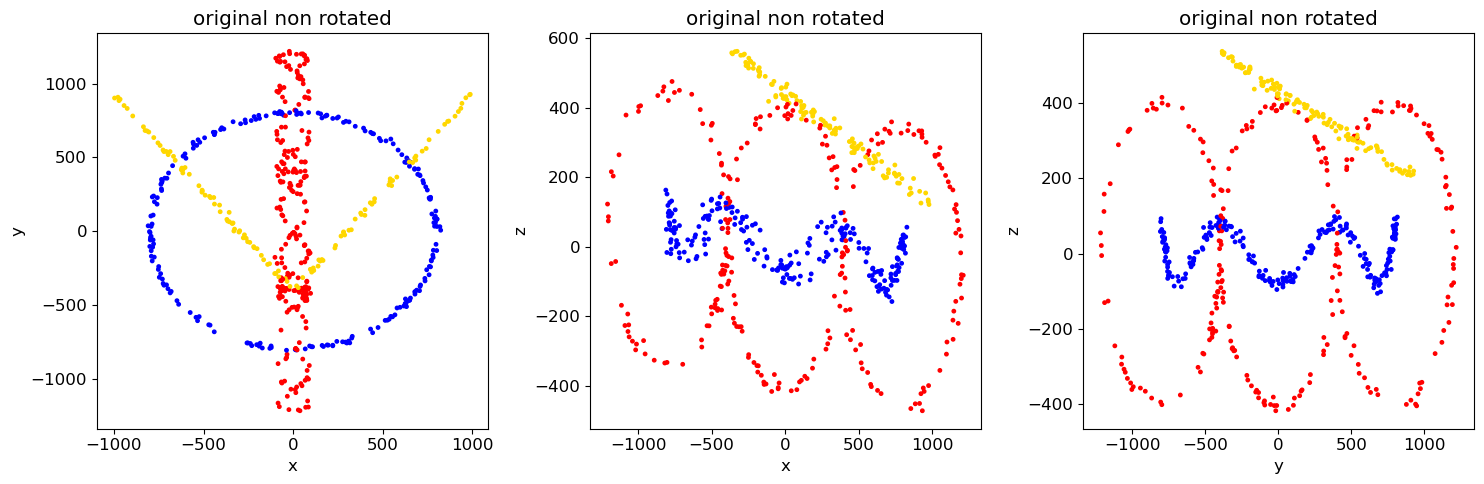

In [30]:
dataT = data.T
U, spectrum, Vt = la.svd(dataT)
rotated_data = np.dot(U[:, :3].T, dataT).T  # Take first 3 components


kmeans_denoise = KMeans(n_clusters=k, n_init=40)
y_kmeans_denoise = kmeans_denoise.fit_predict(rotated_data)  # Get cluster labels


mycmap = ListedColormap(["blue", "red", "gold"])
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 


nmi_kmeans_denoise=NMI(y_true, y_kmeans_denoise)
axes[0].scatter(rotated_data[:, 0], rotated_data[:, 1], c=y_kmeans_denoise, cmap=mycmap, s=6)
axes[0].scatter(kmeans_denoise.cluster_centers_[:, 0], kmeans_denoise.cluster_centers_[:, 1], c='black', marker='x', s=100)
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].set_title(f"PCA on rotated data  NMI={nmi_kmeans:.6f}")

axes[1].scatter(rotated_data[:, 0], rotated_data[:, 2], c=y_kmeans_denoise, cmap=mycmap, s=6)
axes[1].scatter(kmeans.cluster_centers_[:, 0], kmeans_denoise.cluster_centers_[:, 2], c='black', marker='x', s=100)
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC3")
axes[1].set_title("PCA on rotated data")

axes[2].scatter(rotated_data[:, 1], rotated_data[:, 2], c=y_kmeans_denoise, cmap=mycmap, s=6)
axes[2].scatter(kmeans_denoise.cluster_centers_[:, 1], kmeans_denoise.cluster_centers_[:, 2], c='black', marker='x', s=100)
axes[2].set_xlabel("PC2")
axes[2].set_ylabel("PC3")
axes[2].set_title("PCA on rotated data")

plt.tight_layout(h_pad=4.0)

#compare tehse results with the original 3D data, so before the 12D rotation
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 

data_3d=np.loadtxt('x_3d.dat', delimiter='\t')

axes[0].scatter(data_3d[:, 0], data_3d[:, 1], c=y_true, cmap=mycmap, s=6)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].set_title("original non rotated")

axes[1].scatter(rotated_data[:, 0], rotated_data[:, 2], c=y_true, cmap=mycmap, s=6)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[1].set_title("original non rotated")

axes[2].scatter(data_3d[:, 1], data_3d[:, 2], c=y_true, cmap=mycmap, s=6)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
axes[2].set_title("original non rotated")

plt.tight_layout(h_pad=4.0)

plt.show()


So even with the denoising the performances don't get better. 
This non-influence of the noise is expected because, looking at the structure of the dataset, it is not the main source of variability that can influence the K-means clustering: we are trying to cluster sets that the regions of space in which they are embedded ointersect. So, since in the k-means clustering a point is assigned to the closest cluster center (in the iteration of the 'maximisation' step), k-means clustering cannot handle successfully a data structure like the one here being considered, also because of the very different shapes of the sets.